In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [15]:
def plot_word_attributions(word_attributions_dict, word):
    plt.figure()
    bins = np.linspace(-0.5, 0.5, 100)
    plt.hist(word_attributions_dict[word]["LABEL_0"], bins, alpha=0.5, label='No Risk')
    plt.hist(word_attributions_dict[word]["LABEL_1"], bins, alpha=0.5, label='Low Risk')
    plt.hist(word_attributions_dict[word]["LABEL_2"], bins, alpha=0.5, label='Moderate Risk')
    plt.hist(word_attributions_dict[word]["LABEL_3"], bins, alpha=0.5, label='Severe Risk')
    plt.legend(loc='upper right')
    os.makedirs('./attribution', exist_ok=True)
    plt.savefig(f'./attribution/{word}.png')

/var/folders/bx/2z1sltn54l3_wm76y3bh1yt40000gn/T/ipykernel_45847/1775300953.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


FileNotFoundError: [Errno 2] No such file or directory: './attribution/</s>.png'

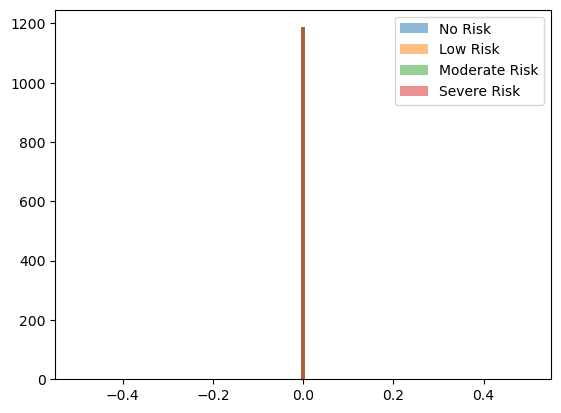

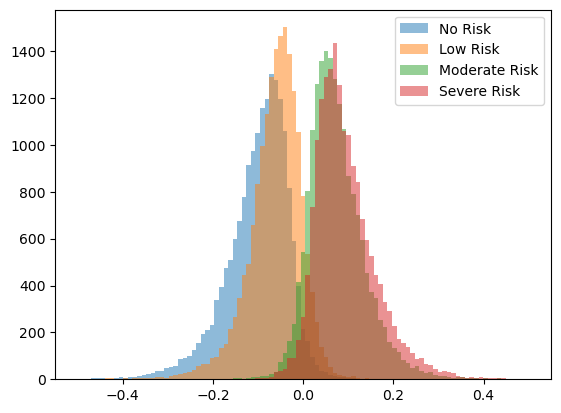

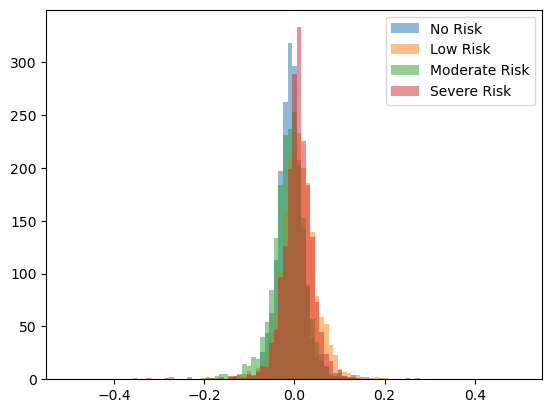

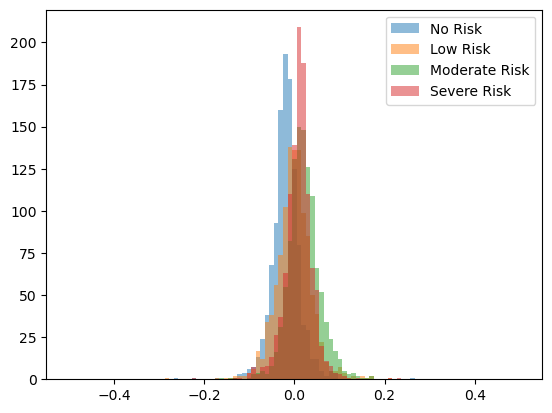

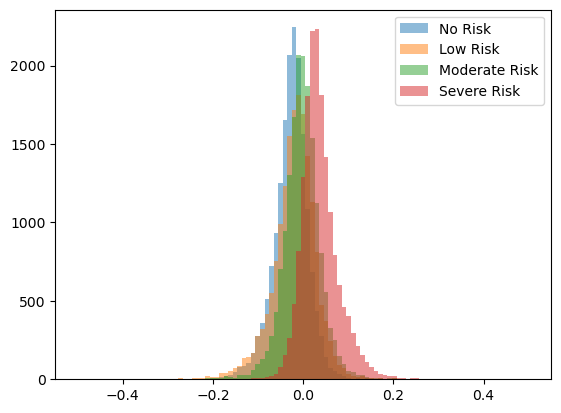

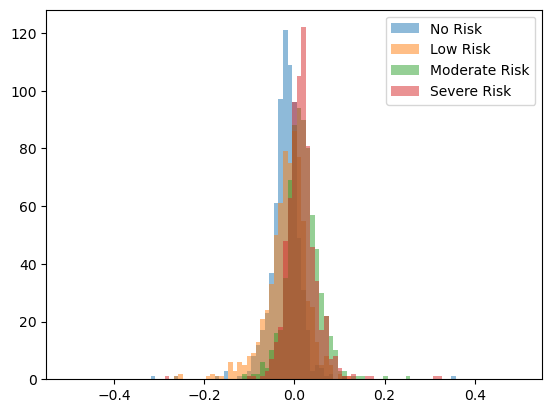

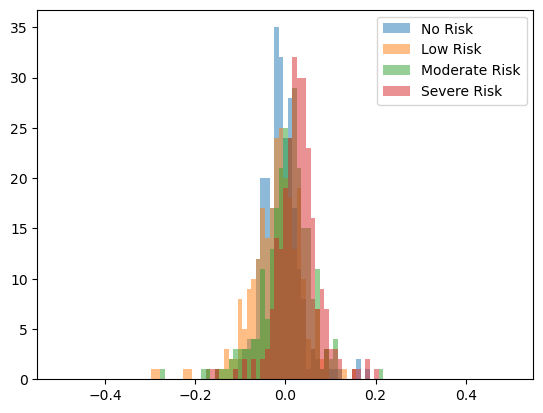

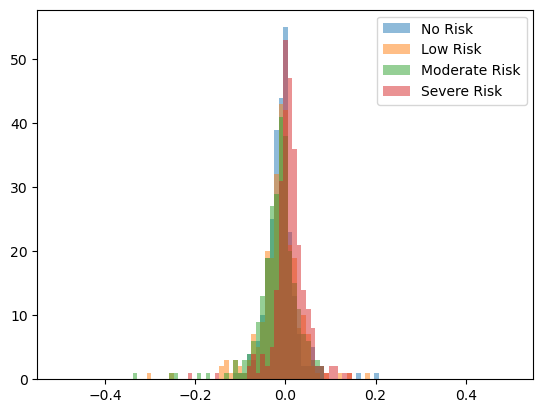

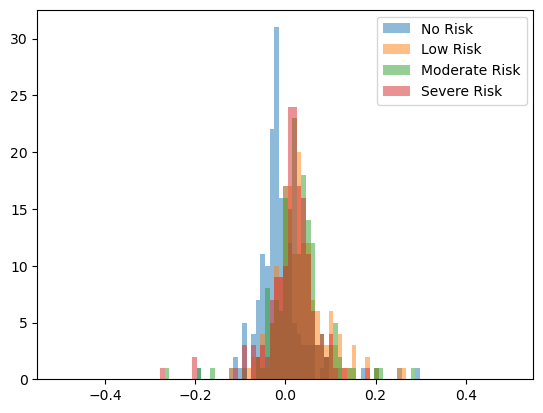

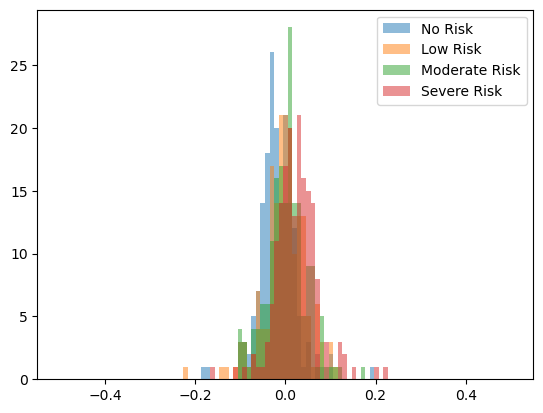

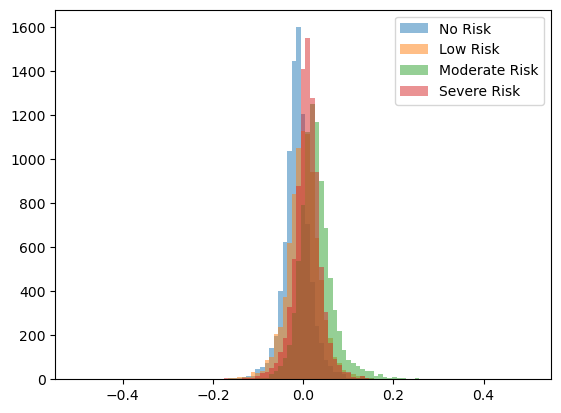

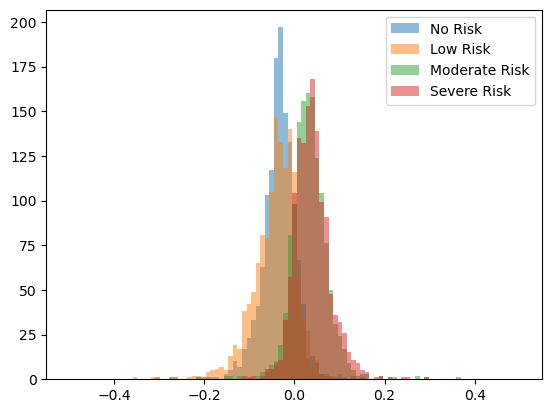

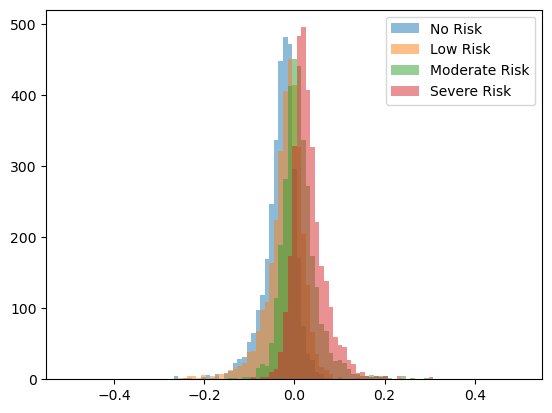

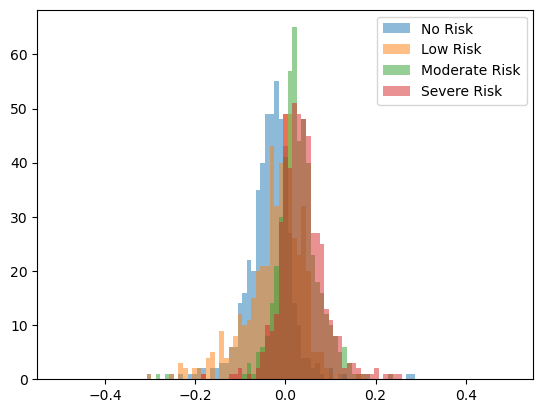

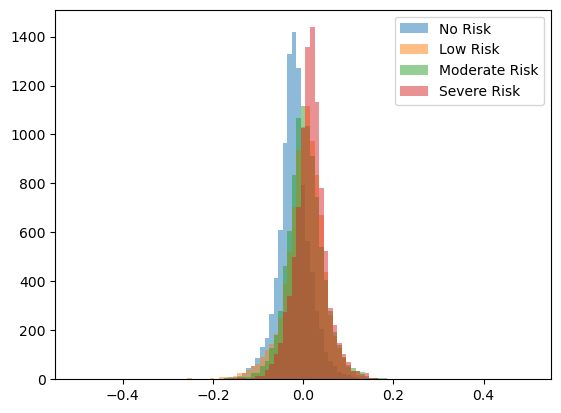

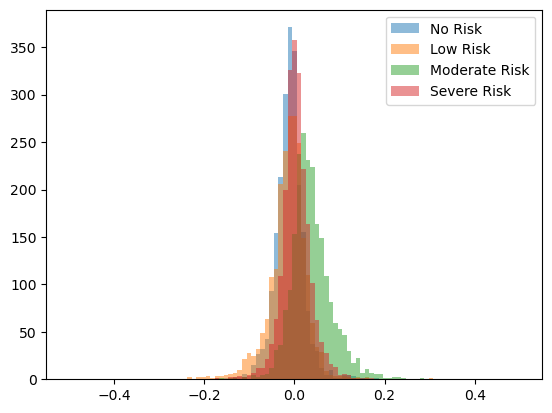

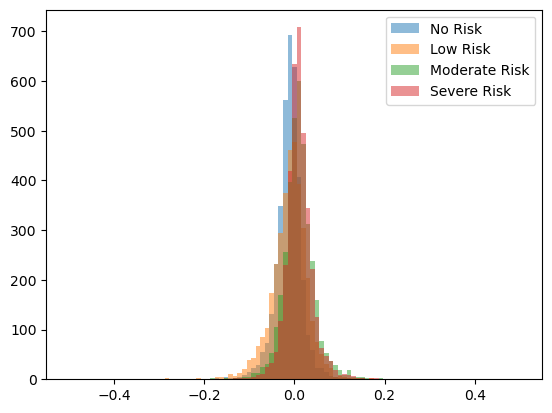

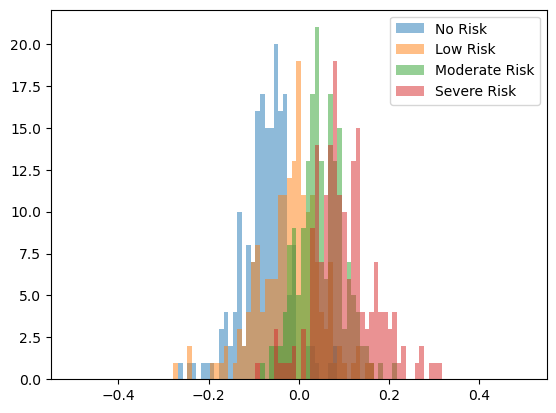

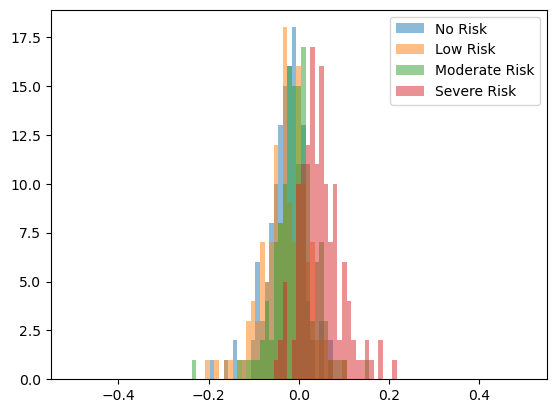

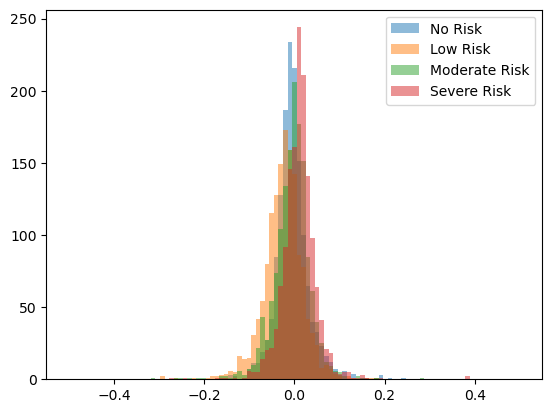

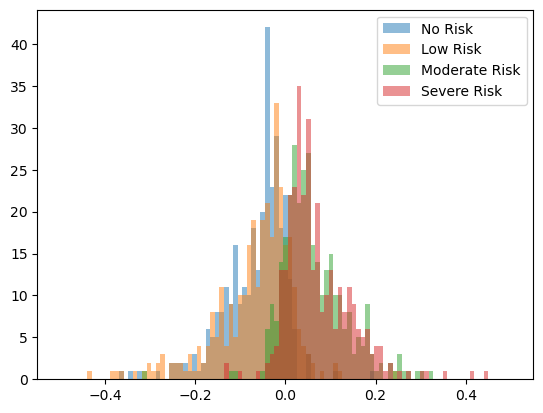

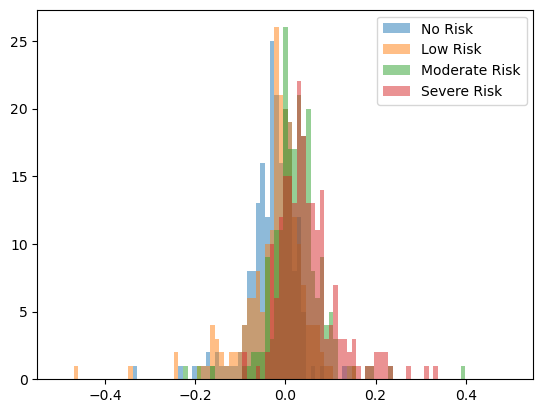

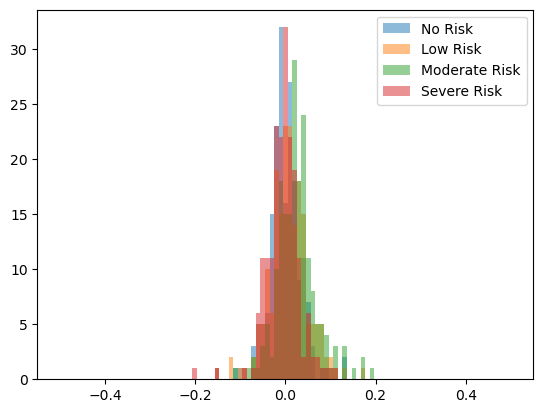

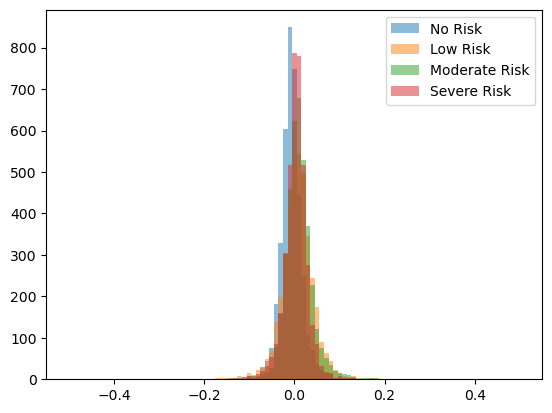

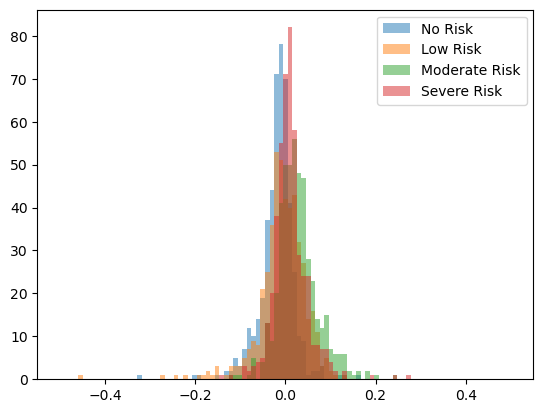

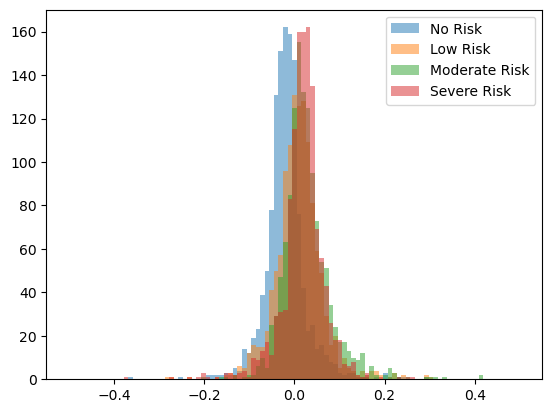

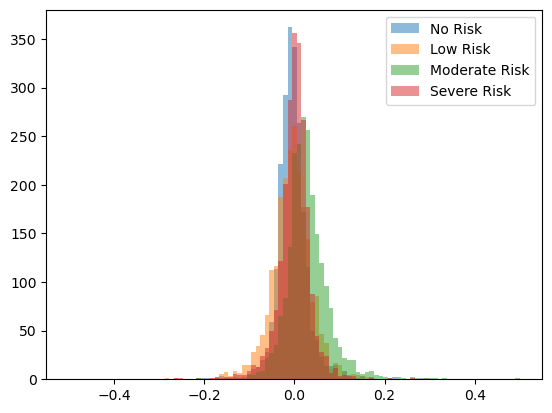

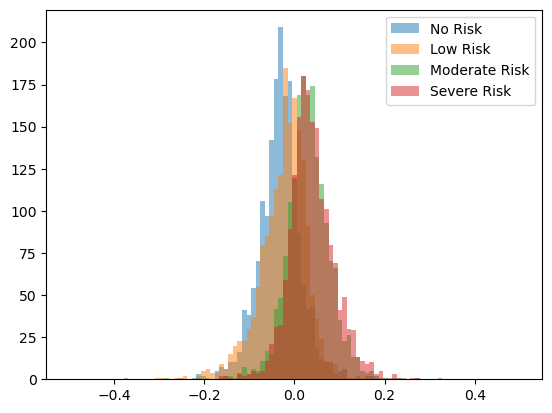

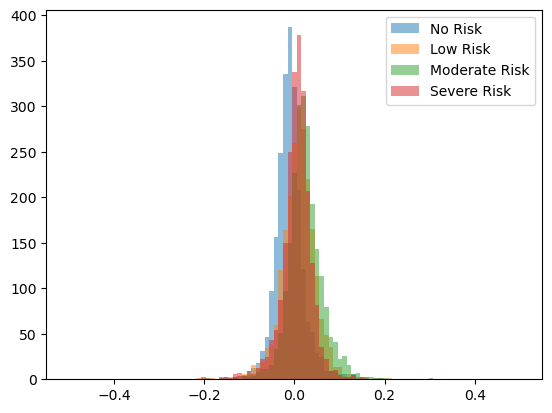

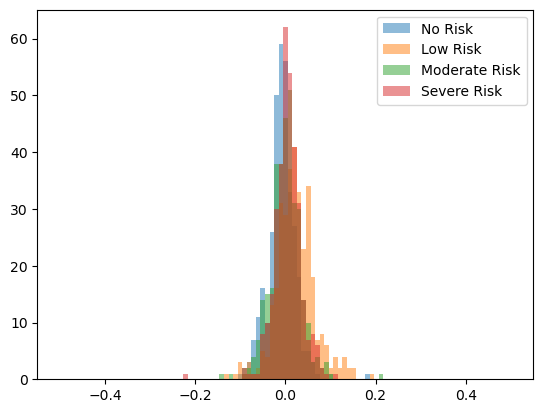

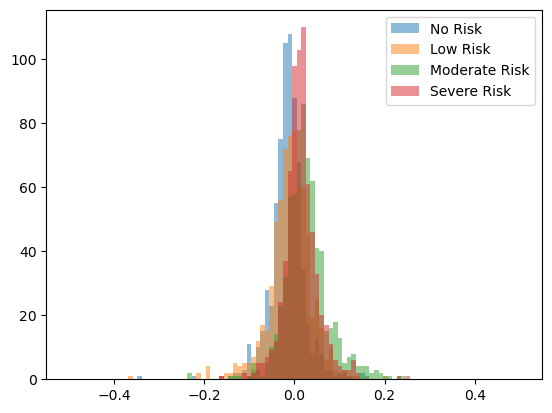

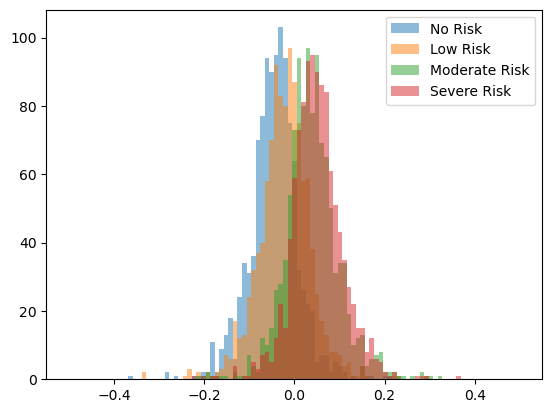

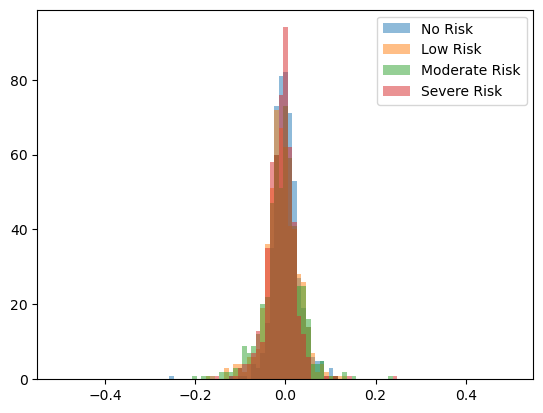

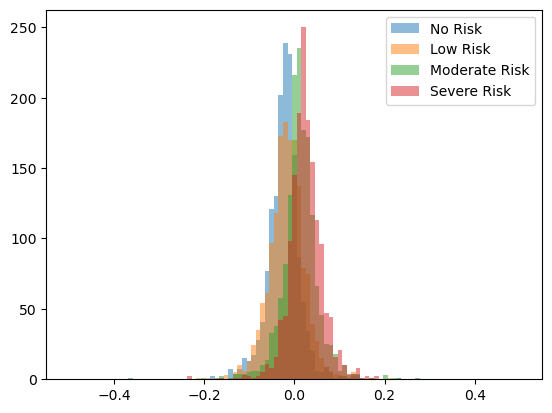

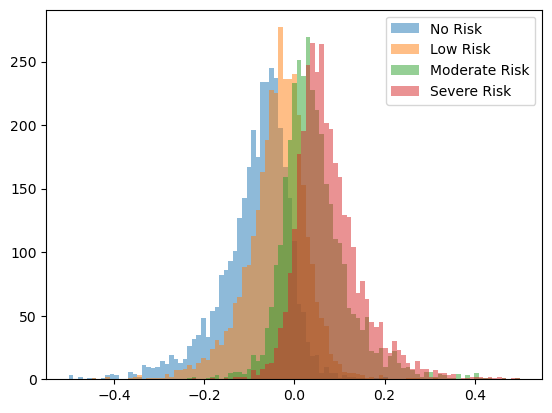

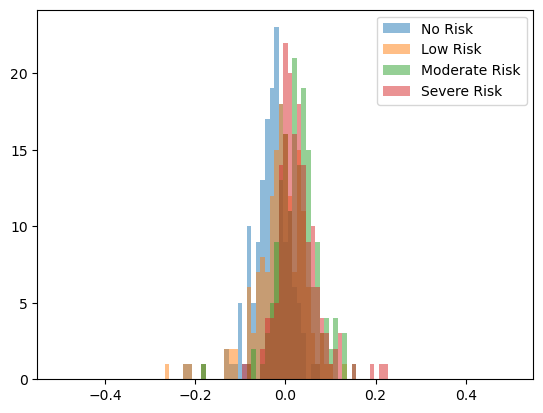

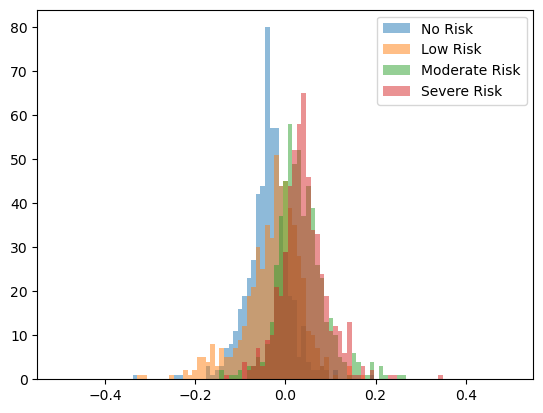

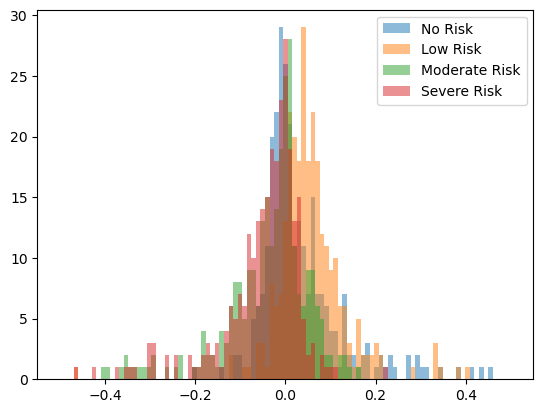

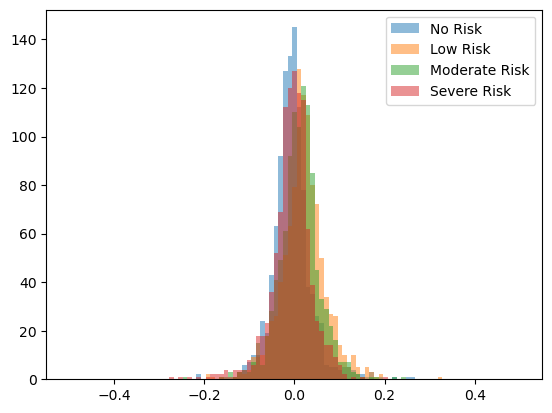

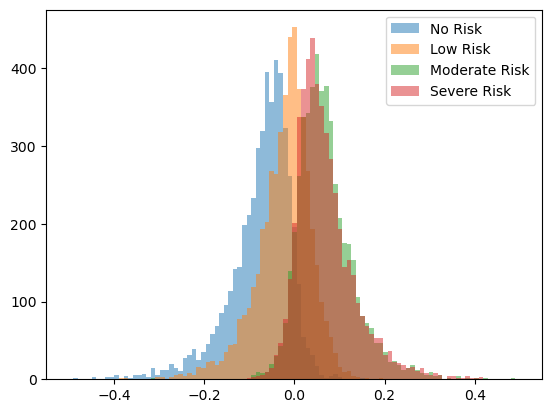

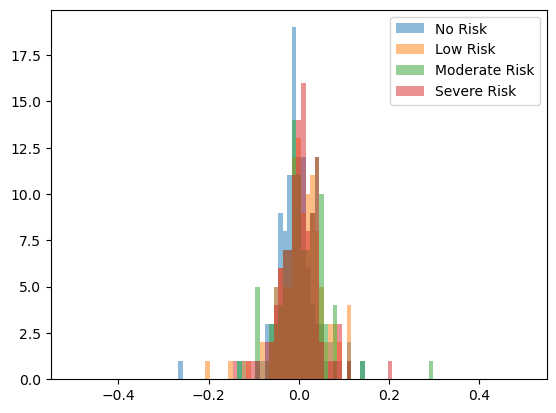

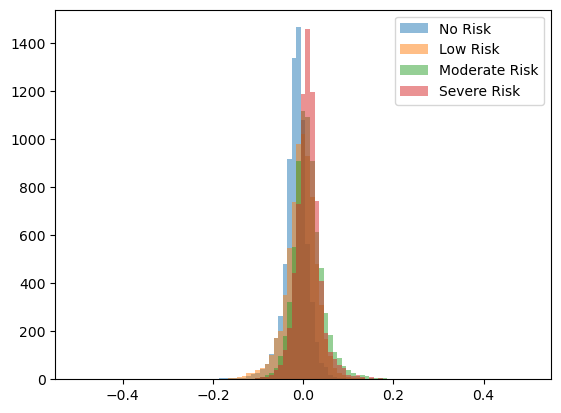

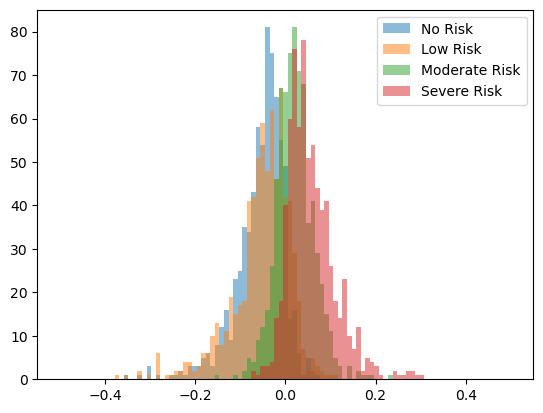

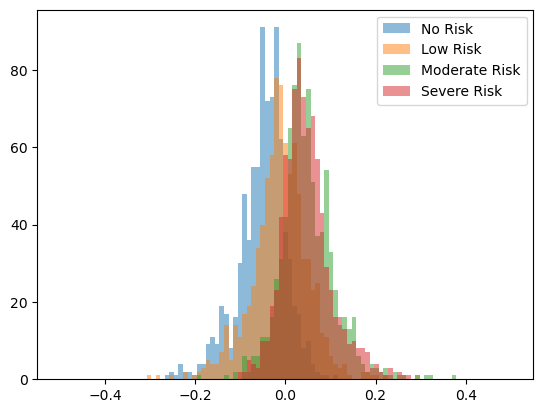

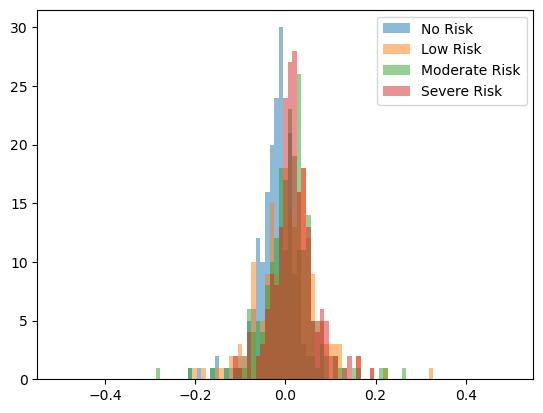

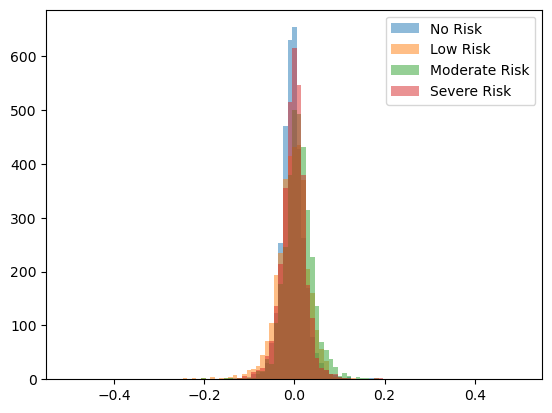

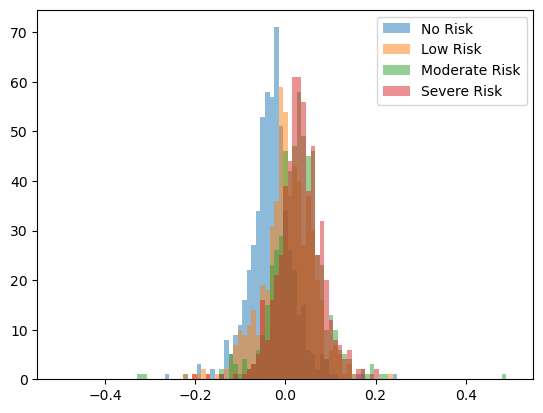

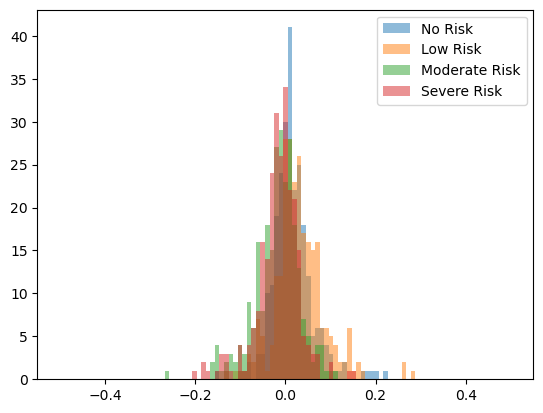

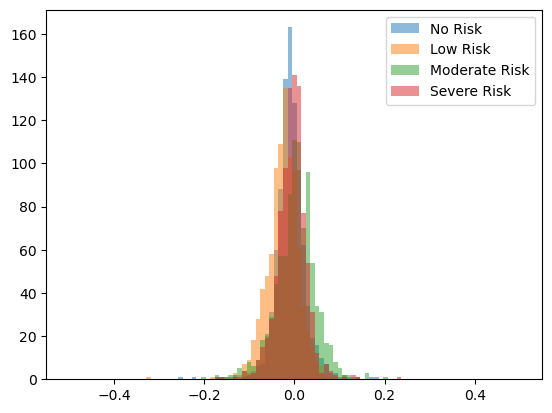

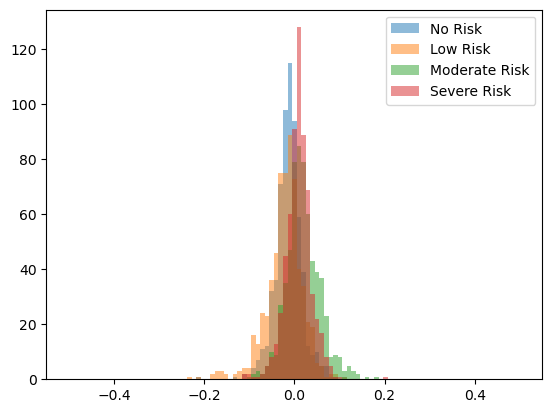

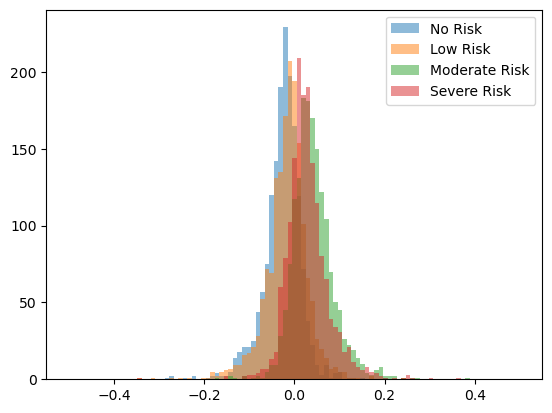

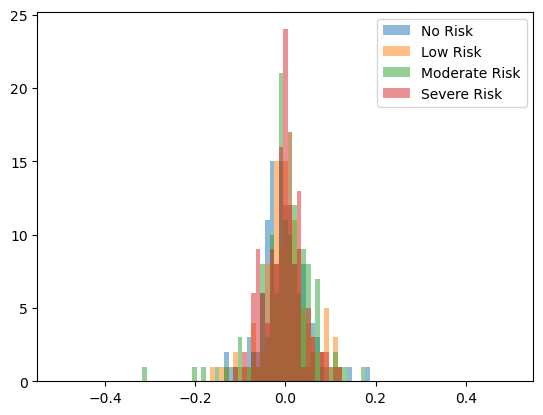

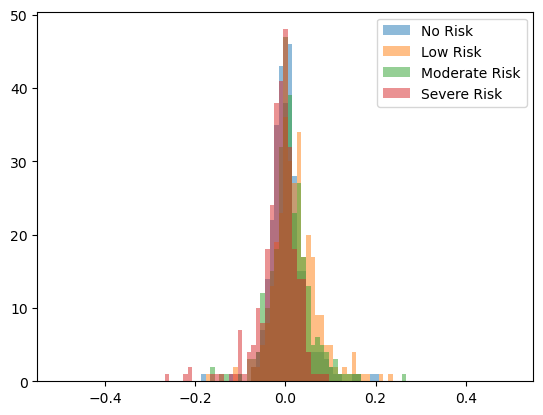

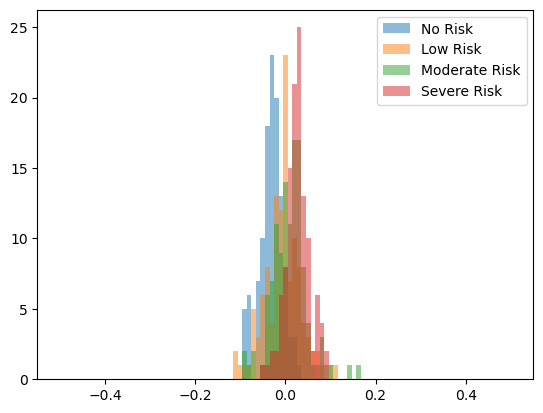

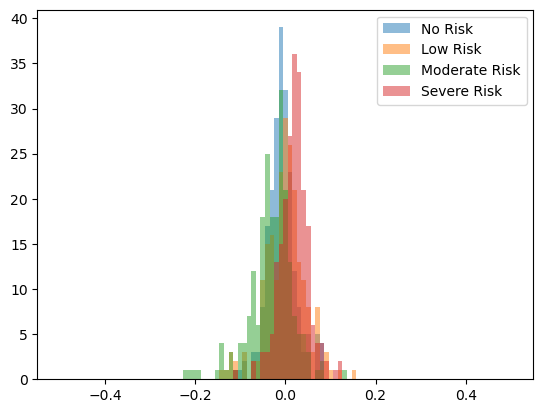

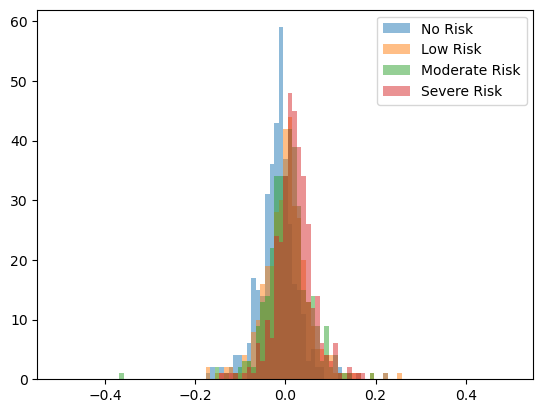

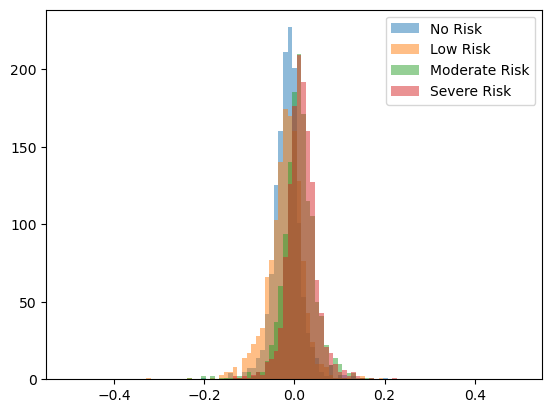

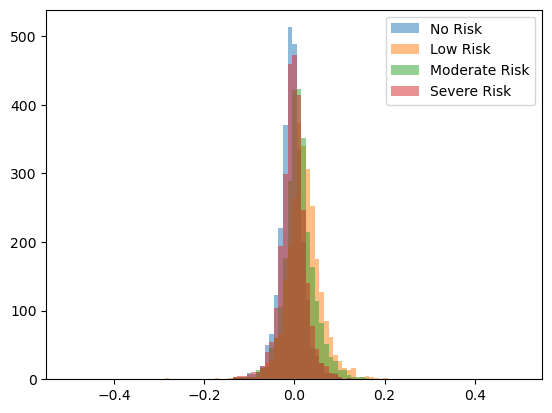

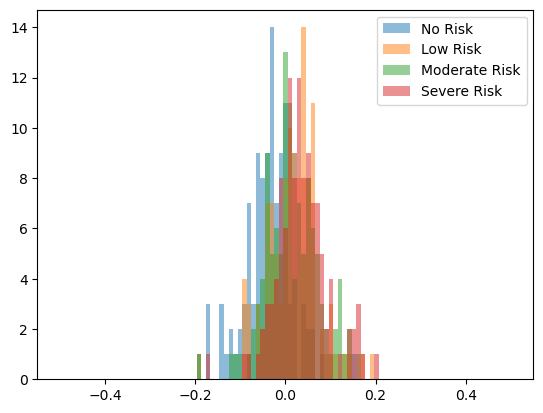

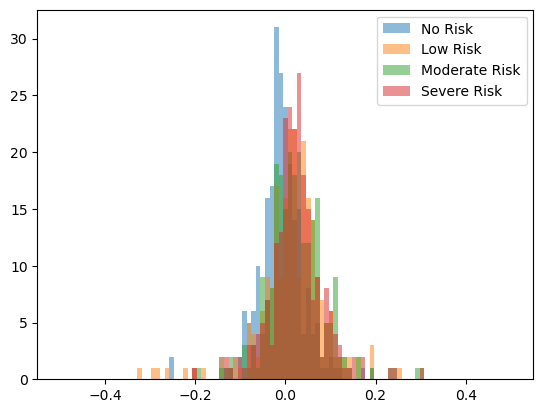

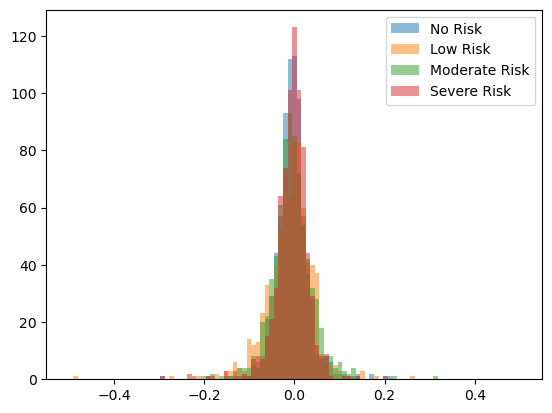

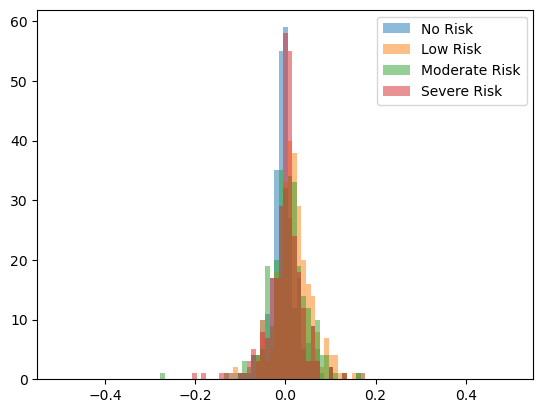

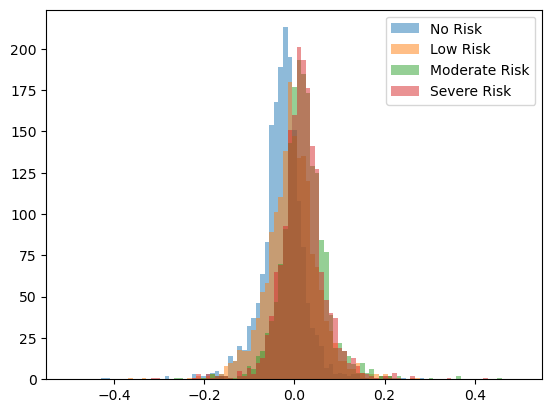

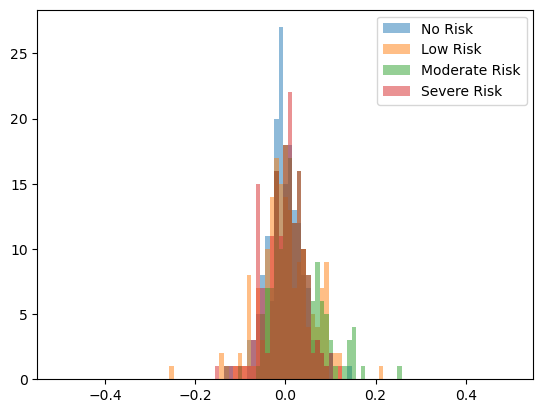

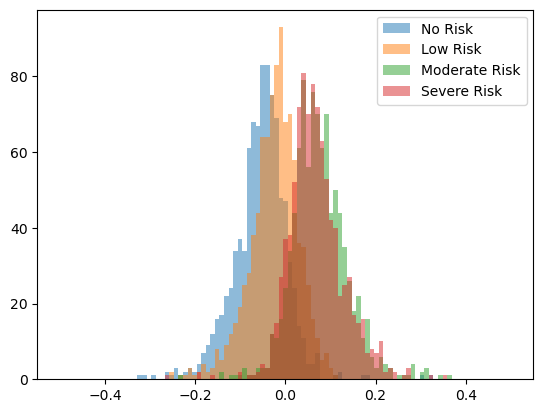

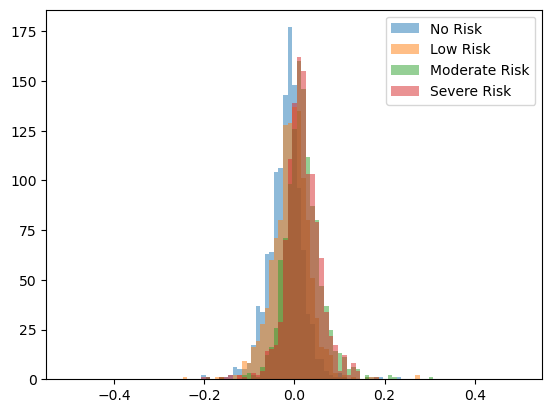

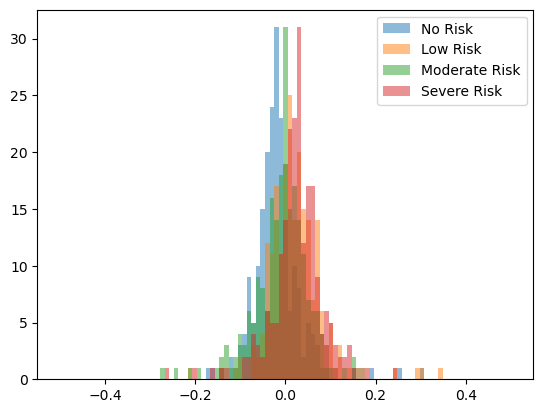

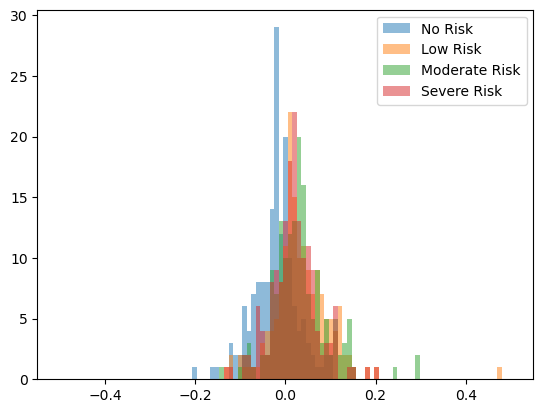

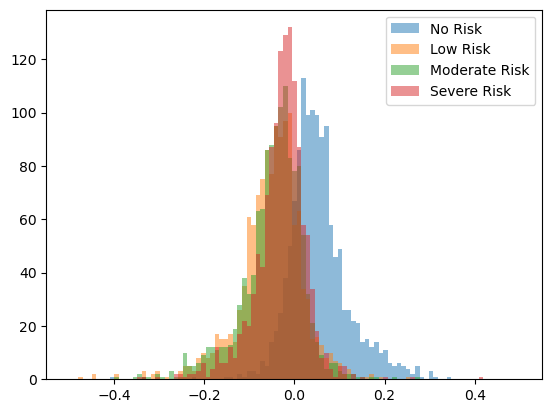

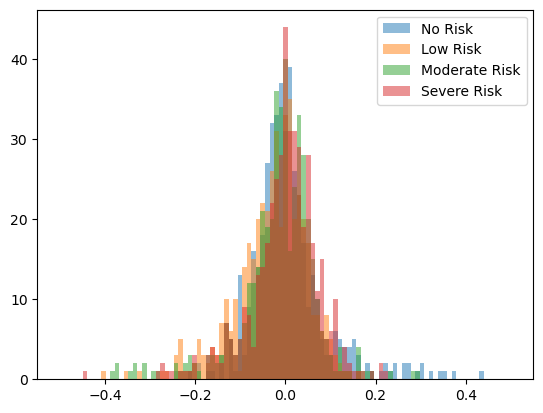

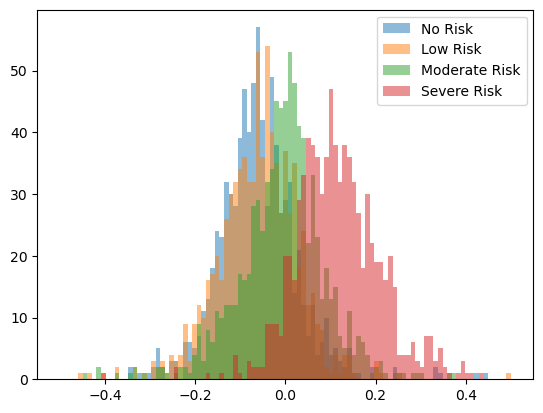

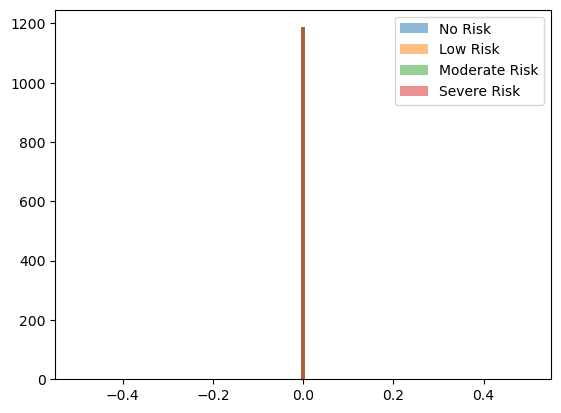

In [16]:
with open('word_attributions.json', 'r') as f:
    word_attributions_dict = json.load(f)

for word in word_attributions_dict:
    if len(word_attributions_dict[word]["LABEL_0"]) > 1000:
        plot_word_attributions(word_attributions_dict, word)

In [5]:
UMD_PATH = "./umd_reddit_suicidewatch_dataset_v2/"

In [6]:
df_attributions = pd.read_json("word_attributions.json")
# transpose df
df_attributions = df_attributions.T
# plot occurences
df_attributions['occurences'] = df_attributions['LABEL_0'].apply(lambda x: len(x))

In [7]:
# find median attribution for each label
df_attributions['median_LABEL_0'] = df_attributions['LABEL_0'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_1'] = df_attributions['LABEL_1'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_2'] = df_attributions['LABEL_2'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_3'] = df_attributions['LABEL_3'].apply(lambda x: np.median(x))

In [8]:
# save word median attributions, rename columns
df_attributions_median = df_attributions[['median_LABEL_0', 'median_LABEL_1', 'median_LABEL_2', 'median_LABEL_3']]
df_attributions_median.columns = ['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3']
# transpose and save to dict
word_attributions_dict = df_attributions_median.T.to_dict()

# Use attribution to classify

In [18]:
# # open UMD dataset
# df_umd = pd.read_csv(f"{UMD_PATH}/expert/expert_posts.csv")
# df_labels = pd.read_csv(f"{UMD_PATH}/expert/expert.csv")
# # limit to pose in Suicidewatch
# df_umd = df_umd[df_umd['subreddit'] == 'SuicideWatch']
# # join labels to posts by user_id
# df_umd = df_umd.join(df_labels.set_index('user_id'), on='user_id')
# #drop rows with no label or post_body or post contains 
# df_umd = df_umd.dropna(subset=['post_body','label'])
# # return post_body and label only
# df_umd = df_umd[['post_body', 'label']]

In [38]:
from umd.umd_data_gen import _corpus_loader
df_corpus = _corpus_loader(f"{UMD_PATH}/crowd/test/shared_task_posts_test.csv",f"{UMD_PATH}/crowd/test/crowd_test_A.csv")

In [10]:
df_corpus

,text,label
0,"I mean really, I think about it, I don't want ...",c
1,So where to begin... So I have facets of my li...,c
2,I would be willing to talk to you on the phone...,a
3,"Hi guys, I'm not on the verge of committing su...",a
4,"I'm getting through this a mutual friend, but ...",a
...,...,...
181,Arrested for 7 misdemeanors and just got accep...,d
182,I've stopped seeing my therapist and stopped m...,d
183,"I had the gun in my mouth pointed, I think, at...",d
184,Everything is wrapping up nicely. My roommate ...,d


In [12]:
# load mental roberta tokenizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "mental/mental-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [40]:
# tokenize text df_corpus
df_corpus['tokenized'] = df_corpus['text'].apply(lambda x: tokenizer(x, return_tensors="pt"))
# convert token id to word
df_corpus['tokenized'] = df_corpus['tokenized'].apply(lambda x: tokenizer.convert_ids_to_tokens(x['input_ids'][0]))

In [41]:
# remove <s> and </s> tokens
df_corpus['tokenized'] = df_corpus['tokenized'].apply(lambda x: x[1:-1])
# remove Ġ from words
df_corpus['tokenized'] = df_corpus['tokenized'].apply(lambda x: [word.replace('Ġ', '') for word in x])
# remove non alpha numeric words
df_corpus['tokenized'] = df_corpus['tokenized'].apply(lambda x: [word for word in x if word.isalnum()])

In [42]:
# using word_attributions_dict, find attribution for each word for each label in tokenized
df_corpus['attribution'] = df_corpus['tokenized'].apply(lambda x: [word_attributions_dict[word] for word in x if word in word_attributions_dict])

In [43]:
# separate attribution for each label to columns, sum attribution for each label
df_corpus['LABEL_0'] = df_corpus['attribution'].apply(lambda x: sum([word['LABEL_0'] for word in x]))
df_corpus['LABEL_1'] = df_corpus['attribution'].apply(lambda x: sum([word['LABEL_1'] for word in x]))
df_corpus['LABEL_2'] = df_corpus['attribution'].apply(lambda x: sum([word['LABEL_2'] for word in x]))
df_corpus['LABEL_3'] = df_corpus['attribution'].apply(lambda x: sum([word['LABEL_3'] for word in x]))

In [44]:
# find label with max attribution
df_corpus['label_predict'] = df_corpus[['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3']].idxmax(axis=1)

In [45]:
# map LABEL_0 to a, LABEL_1 to b, LABEL_2 to c, LABEL_3 to d
mapper = {'LABEL_0': 'a', 'LABEL_1': 'b', 'LABEL_2': 'c', 'LABEL_3': 'd'}
df_corpus['label_predict'] = df_corpus['label_predict'].map(mapper)

              precision    recall  f1-score   support

           a       1.00      0.03      0.06        34
           b       0.00      0.00      0.00        13
           c       0.33      0.33      0.33        39
           d       0.60      0.77      0.67        95

    accuracy                           0.48       181
   macro avg       0.48      0.28      0.27       181
weighted avg       0.57      0.48      0.44       181



<Axes: >

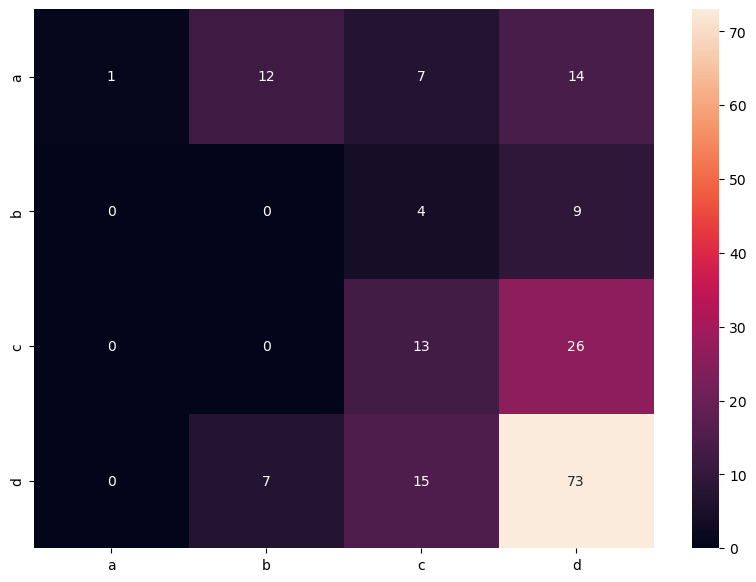

In [47]:
# run classification report on label_predict and label
from sklearn.metrics import classification_report
print(classification_report(df_corpus['label'], df_corpus['label_predict']))

# run confusion matrix on label_predict and label
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_corpus['label'], df_corpus['label_predict'])
# plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in "abcd"],
                    columns = [i for i in "abcd"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

              precision    recall  f1-score   support

           a       1.00      0.03      0.06        34
           b       0.82      1.00      0.90       147

    accuracy                           0.82       181
   macro avg       0.91      0.51      0.48       181
weighted avg       0.85      0.82      0.74       181



<Axes: >

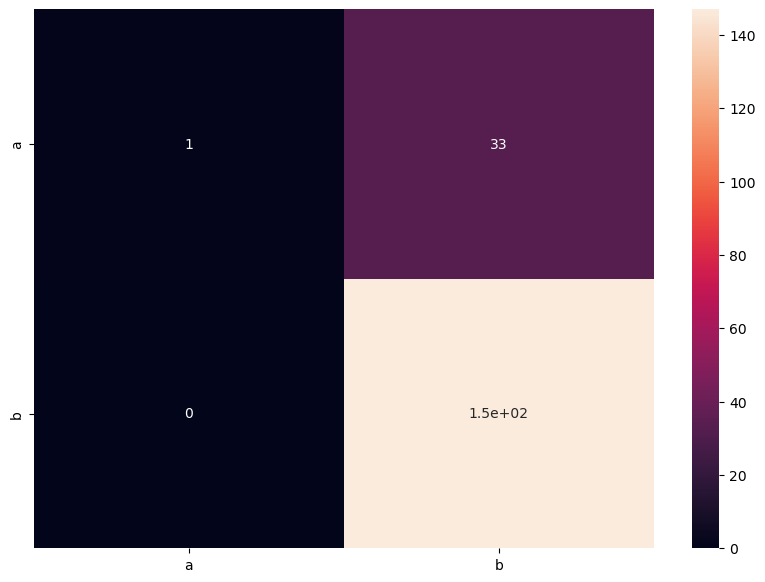

In [52]:
# make another copy of df_corpus
df_corpus_bcd = df_corpus.copy()
# group b,c,d to label b, run classification report and confusion matrix again
df_corpus_bcd['label_predict'] = df_corpus_bcd['label_predict'].apply(lambda x: 'b' if x in ['b', 'c', 'd'] else x)
df_corpus_bcd['label'] = df_corpus_bcd['label'].apply(lambda x: 'b' if x in ['b', 'c', 'd'] else x)
print(classification_report(df_corpus_bcd['label'], df_corpus_bcd['label_predict']))
cm = confusion_matrix(df_corpus_bcd['label'], df_corpus_bcd['label_predict'])
df_cm = pd.DataFrame(cm, index = [i for i in "ab"],
                    columns = [i for i in "ab"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

              precision    recall  f1-score   support

           a       0.65      0.28      0.39        47
           d       0.79      0.95      0.86       134

    accuracy                           0.77       181
   macro avg       0.72      0.61      0.62       181
weighted avg       0.75      0.77      0.74       181



<Axes: >

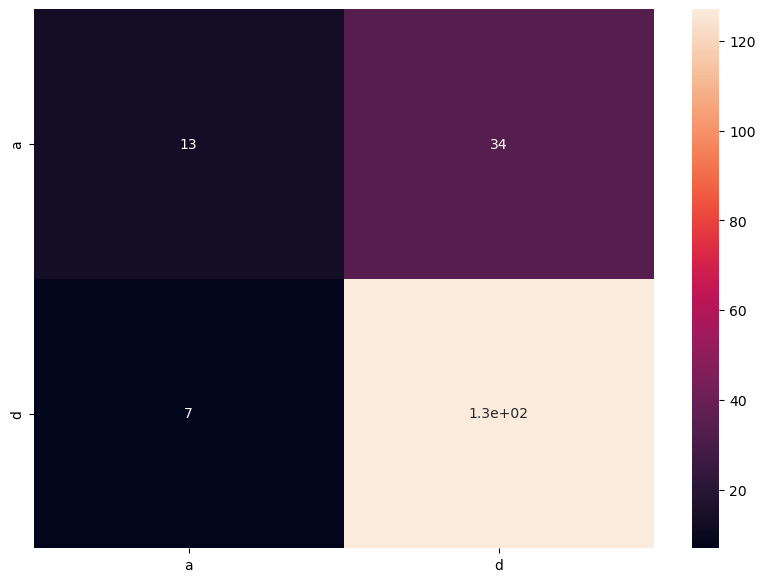

In [58]:
# make another copy of df_corpus
df_corpus_ab_cd = df_corpus.copy()
# group a,b to a, c,d to d, run classification report and confusion matrix again
df_corpus_ab_cd['label_predict'] = df_corpus_ab_cd['label_predict'].apply(lambda x: 'a' if x in ['a', 'b'] else 'd')
df_corpus_ab_cd['label'] = df_corpus_ab_cd['label'].apply(lambda x: 'a' if x in ['a', 'b'] else 'd')
print(classification_report(df_corpus_ab_cd['label'], df_corpus_ab_cd['label_predict']))
cm = confusion_matrix(df_corpus_ab_cd['label'], df_corpus_ab_cd['label_predict'])
df_cm = pd.DataFrame(cm, index = [i for i in "ad"], 
                    columns = [i for i in "ad"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)